#  Feature Engineering: Discretization (Binning)
---
**Notebook:** Discretization | **Dataset:** Titanic | **Model:** DecisionTreeClassifier  
**Goal:** Convert continuous numerical features (Age, Fare) into discrete bins and evaluate impact on model accuracy.


##  What is Discretization (Binning)?

**Discretization** (also called **Binning** or **Bucketing**) converts continuous numerical features  
into **discrete ordered categories (bins)**. Instead of using the exact value, the model sees which "bucket" the value falls in.

### Example — Age Binning:
| Raw Age Values | Bin Label | Count |
|----------------|-----------|-------|
| 5, 12, 18 | Child | 3 |
| 25, 33 | Young Adult | 2 |
| 41, 55, 62 | Middle Aged | 3 |
| 78, 85 | Senior | 2 |

###  Benefits of Discretization:
- **Handles outliers:** Extreme values are grouped into edge bins instead of dominating the model
- **Reduces noise:** Small random variations within a bin become irrelevant
- **Can reveal non-linear patterns** that linear models would otherwise miss
- **Useful for decision trees**, which split on thresholds anyway

###  Strategies in `KBinsDiscretizer`:
| Strategy | Description |
|----------|-------------|
| `uniform` | All bins have equal width |
| `quantile` | All bins have equal number of samples |
| `kmeans` | Bins are based on k-means clustering |


### Import Libraries

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import KBinsDiscretizer  # Main tool for binning
from sklearn.compose import ColumnTransformer       # Apply different transforms per column
import warnings
warnings.filterwarnings('ignore')


###  Load & Prepare Data

We use the Titanic dataset, keeping only `Age`, `Fare` (continuous features) and `Survived` (target).  
Both `Age` and `Fare` are continuous — good candidates for discretization.


In [19]:
data = pd.read_csv('train.csv', usecols=['Age', 'Fare', 'Survived'])

# Drop rows where Age is missing (177 nulls), Fare has no nulls
data.dropna(inplace=True)

data.head(2)  # Preview cleaned data


,Survived,Age,Fare
0,0,22.0,7.2500
1,1,38.0,71.2833


###  Define Features & Target, Then Split

In [21]:
X = data.drop(columns=['Survived'])  # Features: Age and Fare
y = data['Survived']                  # Target: binary survival label


In [22]:
X.head(2)  # Continuous features before discretization


,Age,Fare
0,22.0,7.2500
1,38.0,71.2833


In [23]:
y.head(2)  # Target labels


0    0
1    1
Name: Survived, dtype: int64

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print('Shape of X_train : ', X_train.shape)
print('Shape of y_train : ', y_train.shape)
print('Shape of X_test  : ', X_test.shape)
print('Shape of y_test  : ', y_test.shape)


Shape of X_train :  (571, 2)
Shape of y_train :  (571,)
Shape of X_test  :  (143, 2)
Shape of y_test  :  (143,)


###  Baseline — Without Binning

Train a DecisionTreeClassifier on raw continuous `Age` and `Fare`.  
This is our **baseline** to measure improvement (or regression) after discretization.


In [26]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)  # Train on raw continuous features


DecisionTreeClassifier()

In [27]:
y_pred = clf.predict(X_test)
print('Test Accuracy (without Binning):', accuracy_score(y_test, y_pred))
print('CV Accuracy   (without Binning):', np.mean(cross_val_score(clf, X, y, scoring='accuracy', cv=10)))


Test Accuracy (without Binning): 0.6363636363636364
CV Accuracy   (without Binning): 0.6359350547730829


###  With Discretization (KBinsDiscretizer)

### Strategy chosen: `quantile` with 10 bins
- **Quantile binning** ensures each bin contains roughly the same number of passengers
- This is useful when data is skewed (Fare in Titanic is highly right-skewed)
- We apply separate bin learners to `Age` and `Fare` independently

### Encode: `ordinal`
- Bins are represented as integers: 0, 1, 2, ..., n_bins-1
- This preserves the **ordered** nature of bins (bin 3 > bin 2 > bin 1)


In [29]:
# Create separate KBinsDiscretizer for Age and Fare
# n_bins=10: split each feature into 10 bins
# encode='ordinal': output bin indices as integers (0 to 9)
# strategy='quantile': each bin contains ~equal number of samples
kbin_age  = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
kbin_fare = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')


In [30]:
# Apply Age binarizer to column index 0, Fare to column index 1
trf = ColumnTransformer([
    ('first',  kbin_age,  [0]),  # Column 0 = Age
    ('second', kbin_fare, [1])   # Column 1 = Fare
])


In [31]:
# Fit on training data only, then transform both splits
X_train_trf = trf.fit_transform(X_train)
X_test_trf  = trf.transform(X_test)  # Uses thresholds learned from X_train


In [32]:
# Inspect the bin edges learned from training data
# These are the threshold values separating each bin
print('Age bin edges  :', trf.named_transformers_['first'].bin_edges_)
print('Fare bin edges :', trf.named_transformers_['second'].bin_edges_)


Age bin edges  : [array([ 0.42, 14.  , 19.  , 22.  , 25.  , 28.5 , 32.  , 36.  , 42.  ,
        50.  , 80.  ])                                                ]
Fare bin edges : [array([  0.    ,   7.75  ,   7.8958,   9.225 ,  13.    ,  15.75  ,
         26.    ,  29.125 ,  51.4792,  82.1708, 512.3292])         ]


In [33]:
# Create a comparison DataFrame to see original vs binned values side by side
output = pd.DataFrame({
    'age':      X_train['Age'],
    'age_trf':  X_train_trf[:, 0],   # Binned age (0-9)
    'fare':     X_train['Fare'],
    'fare_trf': X_train_trf[:, 1]    # Binned fare (0-9)
})


In [34]:
output.sample()  # Sample row to inspect original vs discretized values


,age,age_trf,fare,fare_trf
156,16.0,1.0,7.7333,0.0


In [35]:
# Add human-readable interval labels using pd.cut + the learned bin edges
output['age_labels']  = pd.cut(x=X_train['Age'],  bins=trf.named_transformers_['first'].bin_edges_[0].tolist())
output['fare_labels'] = pd.cut(x=X_train['Fare'], bins=trf.named_transformers_['second'].bin_edges_[0].tolist())
output.sample(5)  # See bin intervals alongside numeric bin indices


,age,age_trf,fare,fare_trf,age_labels,fare_labels
791,16.0,1.0,26.0000,6.0,"(14.0, 19.0]","(15.75, 26.0]"
133,29.0,5.0,26.0000,6.0,"(28.5, 32.0]","(15.75, 26.0]"
8,27.0,4.0,11.1333,3.0,"(25.0, 28.5]","(9.225, 13.0]"
280,65.0,9.0,7.7500,1.0,"(50.0, 80.0]","(0.0, 7.75]"
769,32.0,6.0,8.3625,2.0,"(28.5, 32.0]","(7.896, 9.225]"


In [36]:
clf = DecisionTreeClassifier()
clf.fit(X_train_trf, y_train)  # Train on discretized features


DecisionTreeClassifier()

In [37]:
y_pred1 = clf.predict(X_test_trf)
print('Test Accuracy (with Binning):', accuracy_score(y_test, y_pred1))

# Cross-validate on full discretized dataset
X_trf = trf.fit_transform(X)
print('CV Accuracy   (with Binning):', np.mean(cross_val_score(DecisionTreeClassifier(), X, y, cv=10, scoring='accuracy')))


Test Accuracy (with Binning): 0.6223776223776224
CV Accuracy   (with Binning): 0.6317292644757433


### Hyperparameter Experiment — Try Different Bins & Strategies

The function below lets us explore how the **number of bins** and **binning strategy** affect accuracy.  
It also plots histograms before and after transformation for both Age and Fare.


In [39]:
def discretize(bins, strategy):
    """
    Discretize Age and Fare with given bin count and strategy.
    Prints cross-validated accuracy and plots distribution before/after.
    
    Parameters:
    -----------
    bins     : int   — Number of bins to create
    strategy : str   — 'uniform', 'quantile', or 'kmeans'
    """
    kbin_age  = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy=strategy)
    kbin_fare = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy=strategy)
    trf = ColumnTransformer([
        ('first',  kbin_age,  [0]),
        ('second', kbin_fare, [1])
    ])
    X_trf = trf.fit_transform(X)
    print(f'CV Accuracy ({strategy}, {bins} bins):', np.mean(cross_val_score(DecisionTreeClassifier(), X, y, cv=10, scoring='accuracy')))

    # Plot distribution of Age before and after
    plt.figure(figsize=(14, 4))
    plt.subplot(121)
    plt.hist(X['Age'], bins=30, color='steelblue', edgecolor='white')
    plt.title('Age — Before Binning')
    plt.subplot(122)
    plt.hist(X_trf[:, 0], bins=bins, color='tomato', edgecolor='white')
    plt.title(f'Age — After Binning ({bins} bins, {strategy})')
    plt.tight_layout()
    plt.show()

    # Plot distribution of Fare before and after
    plt.figure(figsize=(14, 4))
    plt.subplot(121)
    plt.hist(X['Fare'], bins=30, color='steelblue', edgecolor='white')
    plt.title('Fare — Before Binning')
    plt.subplot(122)
    plt.hist(X_trf[:, 1], bins=bins, color='tomato', edgecolor='white')
    plt.title(f'Fare — After Binning ({bins} bins, {strategy})')
    plt.tight_layout()
    plt.show()


CV Accuracy (kmeans, 5 bins): 0.6303012519561815


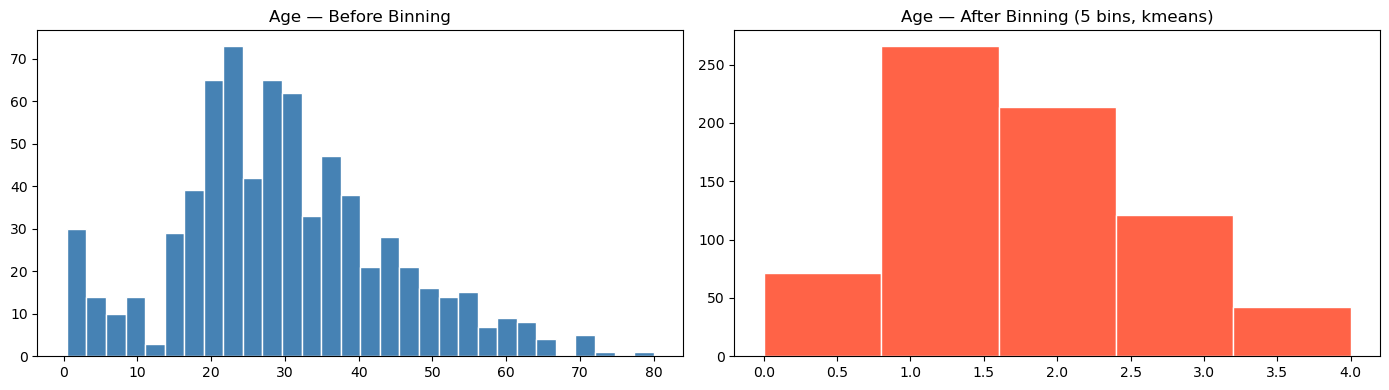

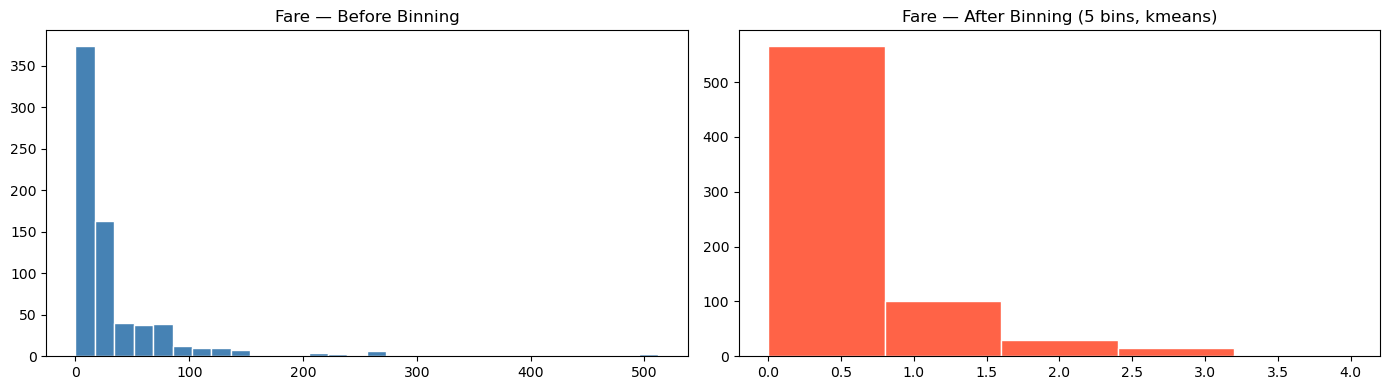

In [40]:
# Try 5 bins with kmeans strategy
# K-means bins cluster similar values together — handles skewed distributions well
discretize(5, 'kmeans')


### Takeaways:
1. **Quantile binning** is often the best default — it handles skewed data like `Fare` well
2. **Number of bins** is a hyperparameter — too few loses information, too many defeats the purpose
3. Decision Trees often perform similarly with or without discretization since they already find splits internally
4. Discretization can help **linear models** more than tree-based models
5. Always **visualize** the distributions before and after to ensure the transformation is sensible
